In [1]:
# Tell python where to look for modules. 
# Depending on how your jupyter handles working directories, this may not be needed.
import sys
sys.path.append('../../hourly-egrid/')

# Greg note: I have found that pathlib.Path.cwd() works well for setting the working directory
from pathlib import Path 
cwd = Path.cwd()

In [2]:
# Third party packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlalchemy as sa

from dateutil.parser import parse as parse_dt

# Greg note: also adding plotly for interactive visualizations
import plotly.express as px

In [3]:
# import our packages
%reload_ext autoreload
%autoreload 2

import src.data_cleaning as data_cleaning

C:\Users\Greg\miniconda3\envs\hourly_egrid\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [4]:
year = 2019

# 1. Compare hourly generation to EIA-930
* Compare emisson rate
* Compare total emission 

In [6]:
hourly_emission_rate = pd.read_csv(cwd / "../data/output/hourly_emission_rate.csv", index_col=0, parse_dates=True)
hourly_net_generation = pd.read_csv(cwd /"../data/output/hourly_net_generation.csv", index_col=0, parse_dates=True)
hourly_net_emissions = pd.read_csv(cwd /"../data/output/hourly_net_emission.csv", index_col=0, parse_dates=True)
hourly_emission_rate.head()

,AEC,AECI,AVA,AVRN,AZPS,BANC,BPAT,CISO,CPLE,CSTO,...,SPA,SRP,SWPP,TAL,TEC,TEPC,TIDC,TVA,WACM,WALC
operating_datetime_utc,,,,,,,,,,,,,,,,,,,,,
2019-01-01 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.660468,NaN,...,NaN,NaN,NaN,0.471681,0.534136,NaN,NaN,1.188027,NaN,NaN
2019-01-01 06:00:00+00:00,0.454045,0.859463,NaN,NaN,NaN,NaN,NaN,NaN,0.664060,NaN,...,1.037423,NaN,0.960496,0.477731,0.550416,NaN,NaN,0.985028,NaN,NaN
2019-01-01 07:00:00+00:00,0.449835,0.862902,NaN,NaN,0.800466,NaN,NaN,NaN,0.659645,NaN,...,1.024447,0.190692,0.937146,0.474420,0.563341,0.157935,NaN,0.986587,1.083537,0.539106
2019-01-01 08:00:00+00:00,0.469767,0.865417,0.41247,0.435513,0.834473,0.574896,0.759043,0.329894,0.659514,0.434392,...,1.032945,0.162165,0.941366,0.480163,0.573574,0.163685,0.077800,1.016743,1.092086,0.323829
2019-01-01 09:00:00+00:00,0.481392,0.864889,0.41373,0.435513,0.824236,0.615730,0.765567,0.334543,0.663090,0.432632,...,1.036996,0.161858,0.937645,0.484387,0.578491,0.162700,0.080062,1.011904,1.098681,0.333634


In [7]:
eia_930_1 = pd.read_csv(f"../data/eia930/EIA930_BALANCE_{year}_Jan_Jun.csv",\
                        index_col="UTC Time at End of Hour", parse_dates=True, thousands=',')
eia_930_2 = pd.read_csv(f"../data/eia930/EIA930_BALANCE_{year}_Jul_Dec.csv",\
                        index_col="UTC Time at End of Hour", parse_dates=True, thousands=',')
eia_930 = pd.concat([eia_930_1, eia_930_2])
eia_930.head()

,Balancing Authority,Data Date,Hour Number,Local Time at End of Hour,Demand Forecast (MW),Demand (MW),Net Generation (MW),Total Interchange (MW),Sum(Valid DIBAs) (MW),Demand (MW) (Imputed),...,Net Generation (MW) from Coal,Net Generation (MW) from Natural Gas,Net Generation (MW) from Nuclear,Net Generation (MW) from All Petroleum Products,Net Generation (MW) from Hydropower and Pumped Storage,Net Generation (MW) from Solar,Net Generation (MW) from Wind,Net Generation (MW) from Other Fuel Sources,Net Generation (MW) from Unknown Fuel Sources,Region
UTC Time at End of Hour,,,,,,,,,,,,,,,,,,,,,
2019-01-01 07:00:00,AEC,01/01/2019,1,01/01/2019 1:00:00 AM,NaN,361.0,414.0,53.0,53.0,NaN,...,-5.0,416.0,NaN,NaN,0.0,NaN,NaN,3.0,NaN,SE
2019-01-01 08:00:00,AEC,01/01/2019,2,01/01/2019 2:00:00 AM,NaN,344.0,376.0,32.0,32.0,NaN,...,-5.0,378.0,NaN,NaN,0.0,NaN,NaN,3.0,NaN,SE
2019-01-01 09:00:00,AEC,01/01/2019,3,01/01/2019 3:00:00 AM,NaN,326.0,355.0,29.0,29.0,NaN,...,-5.0,357.0,NaN,NaN,0.0,NaN,NaN,3.0,NaN,SE
2019-01-01 10:00:00,AEC,01/01/2019,4,01/01/2019 4:00:00 AM,NaN,318.0,356.0,38.0,38.0,NaN,...,-5.0,358.0,NaN,NaN,0.0,NaN,NaN,3.0,NaN,SE
2019-01-01 11:00:00,AEC,01/01/2019,5,01/01/2019 5:00:00 AM,NaN,324.0,357.0,33.0,33.0,NaN,...,-3.0,357.0,NaN,NaN,0.0,NaN,NaN,3.0,NaN,SE


In [17]:
eia_930 = data_cleaning.clean_eia_930(eia_930)
eia_930.index = eia_930.index.tz_localize('UTC')

In [18]:
# EIA-930 also includes categories for other and unknown. Not included as non-renewable here, but maybe should be.
# TODO: check if fuel types always sum to net generation.

# Calculate hourly EIA-930 non-renewable generation 
eia_930["930_generation_non_renewable"] = eia_930[["Net Generation (MW) from Coal",\
                                                  "Net Generation (MW) from Natural Gas",\
                                                  "Net Generation (MW) from All Petroleum Products"]].sum(\
                                                  axis=1)

# Calculate hourly EIA-930 non-renewable generation 
eia_930["930_generation_minus_renewable"] = eia_930["Net Generation (MW)"] - \
                                                  eia_930[["Net Generation (MW) from Nuclear",\
                                                  "Net Generation (MW) from Hydropower and Pumped Storage",\
                                                  "Net Generation (MW) from Solar",\
                                                  "Net Generation (MW) from Wind"]].sum(\
                                                  axis=1)

(18109.0, 18118.0)

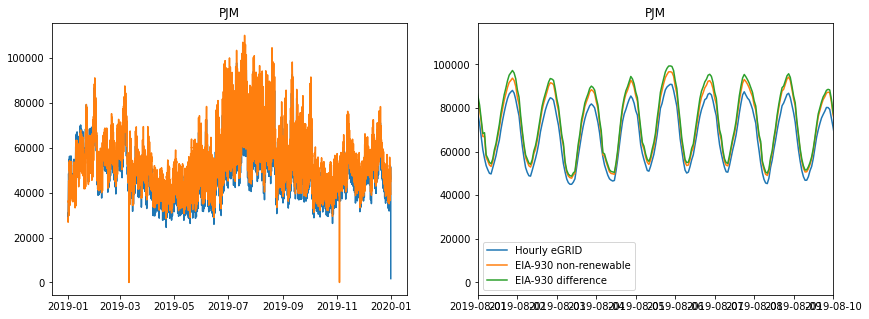

In [384]:
# large BAs with significant discrepancies between eGRID and aggregated CEMS data: PJM, MISO, ERCO
# BAs with bad 930 data: PGE, AVRN, BPAT, "FPL","IPCO","NEVP","SC","TEC","TVA"
ba = "PJM"

fig, (ax, ax2) = plt.subplots(1,2, figsize=(14,5))

ax.plot(hourly_net_generation[ba], label="Hourly eGRID")
ax.plot(eia_930[eia_930["Balancing Authority"]==ba]["930_generation_non_renewable"])
ax.set_title(ba)

ax2.plot(hourly_net_generation[ba], label="Hourly eGRID")
ax2.plot(eia_930[eia_930["Balancing Authority"]==ba]["930_generation_non_renewable"], label="EIA-930 non-renewable")
ax2.plot(eia_930[eia_930["Balancing Authority"]==ba]["930_generation_minus_renewable"], label="EIA-930 difference")
ax2.set_title(ba)
ax2.legend()
ax2.set_xlim(parse_dt("2019-08-01"), parse_dt("2019-08-10"))

In [22]:
ba = "PJM"

data_for_plot = eia_930.loc[eia_930["Balancing Authority"]==ba, ["930_generation_non_renewable","930_generation_minus_renewable"]]
data_for_plot = data_for_plot.merge(hourly_net_generation[ba], how='left', left_index=True, right_index=True)
data_for_plot = data_for_plot.rename(columns={ba:'CEMS'})

px.line(data_for_plot, title=f'Net generation in {ba} EIA-930 vs CEMS')

### Annual EIA-930

Hourly EIA-930 appears to be in good agreement with hourly eGRID numbers, even in areas like PJM where hourly eGRID covers only 60% of actual eGRID non-renewable generation. Is this something about aggregation, or a difference between EIA-930 and actual eGRID? 

In [385]:
# For annual comparison graphs, see below with eGRID
annual_eia_930 = eia_930.groupby("Balancing Authority").sum()[["930_generation_non_renewable","930_generation_minus_renewable"]]
annual_eia_930.head()

,930_generation_non_renewable,930_generation_minus_renewable
Balancing Authority,,
AEC,3194361.0,3199154.0
AECI,22953634.0,22953740.0
AVA,2047287.0,2909232.0
AVRN,716633.0,716633.0
BANC,30464309.0,29915647.0


# 2. Compute annual generation from 923
* Aggregate 923 generation to the BA level 
* In (3), compare aggregated 923 to aggregated hourly eGRID, annual eGRID, and 930

In [24]:
# specify the relative path to the sqllite database, and create an sqalchemy engine
pudl_db = 'sqlite:///../data/pudl/pudl_data/sqlite/pudl.sqlite'
pudl_engine = sa.create_engine(pudl_db)

In [25]:
# PUDL reports 923 monthly generation data across two tables, generation_eia923 and generation_fuel_eia923

# Load generation, filter for year. PUDL says that this only contains ~55% of reported generation 
# (https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/eia923.html)
# Table is large, so filter before load
gen_923 = pd.read_sql(f"SELECT * FROM generation_eia923 \
                           WHERE report_date >= '{year}-01-01' \
                           AND report_date <= '{year}-12-30'", pudl_engine)
gen_923.head()

,plant_id_eia,generator_id,report_date,net_generation_mwh
0,3,1,2019-01-01,-624.0
1,3,1,2019-02-01,-312.0
2,3,1,2019-03-01,1483.0
3,3,1,2019-04-01,-183.0
4,3,1,2019-05-01,6421.0


In [27]:
# load fuel table, filter for year. Table is large so filter before loading into pandas
gen_fuel_923 = pd.read_sql("SELECT * FROM generation_fuel_eia923 \
                           WHERE report_date >= '2019-01-01' \
                           AND report_date <= '2019-12-30'", pudl_engine)
gen_fuel_923.head()

,plant_id_eia,report_date,energy_source_code,fuel_type_code_pudl,fuel_type_code_aer,prime_mover_code,fuel_consumed_units,fuel_consumed_for_electricity_units,fuel_mmbtu_per_unit,fuel_consumed_mmbtu,fuel_consumed_for_electricity_mmbtu,net_generation_mwh
0,1,2019-01-01,DFO,oil,DFO,IC,351.0,351.0,5.825,2045.0,2045.0,195.676
1,1,2019-02-01,DFO,oil,DFO,IC,392.0,392.0,5.825,2283.0,2283.0,217.498
2,1,2019-03-01,DFO,oil,DFO,IC,388.0,388.0,5.825,2260.0,2260.0,215.544
3,1,2019-04-01,DFO,oil,DFO,IC,357.0,357.0,5.825,2080.0,2080.0,198.082
4,1,2019-05-01,DFO,oil,DFO,IC,388.0,388.0,5.825,2260.0,2260.0,215.578


In [389]:
# Are all the plants in gen_923 also in gen_fuel_923?
oneway = np.setdiff1d(gen_923["plant_id_eia"].unique(), gen_fuel_923["plant_id_eia"].unique())
print(f"{len(oneway)} plants in generation_eia923 are not in generation_fuel_eia923")

otherway = np.setdiff1d(gen_fuel_923["plant_id_eia"].unique(),gen_923["plant_id_eia"].unique())
print(f"{len(oneway)} plants in generation_fuel_eia923 are not in generation_eia923")

0 plants in generation_eia923 are not in generation_fuel_eia923
0 plants in generation_fuel_eia923 are not in generation_eia923


Both PUDL tables appear to contain the same plants, but PUDL documentation identifies generation_fuel_eia923 as more complete. We use that table to aggregate...

In [390]:
# Filter for combustion units/fuel only 
# pudl codes also include 'other'. Not included in non-renewables here, but may include biomass
gen_fuel_923 = gen_fuel_923[gen_fuel_923.fuel_type_code_pudl.isin(['oil', 'gas', 'coal', 'waste'])]

In [391]:
# load the plants_entity_eia data
plants_ba = pd.read_sql("SELECT balancing_authority_code_eia, plant_id_eia \
                            FROM plants_entity_eia", pudl_engine)

# Add ba code to generation_fuel_eia923
gen_fuel_923 = gen_fuel_923.merge(plants_ba, how='left', on='plant_id_eia')

In [392]:
gen_fuel_923.head()

,plant_id_eia,report_date,energy_source_code,fuel_type_code_pudl,fuel_type_code_aer,prime_mover_code,fuel_consumed_units,fuel_consumed_for_electricity_units,fuel_mmbtu_per_unit,fuel_consumed_mmbtu,fuel_consumed_for_electricity_mmbtu,net_generation_mwh,balancing_authority_code_eia
0,1,2019-01-01,DFO,oil,DFO,IC,351.0,351.0,5.825,2045.0,2045.0,195.676,None
1,1,2019-02-01,DFO,oil,DFO,IC,392.0,392.0,5.825,2283.0,2283.0,217.498,None
2,1,2019-03-01,DFO,oil,DFO,IC,388.0,388.0,5.825,2260.0,2260.0,215.544,None
3,1,2019-04-01,DFO,oil,DFO,IC,357.0,357.0,5.825,2080.0,2080.0,198.082,None
4,1,2019-05-01,DFO,oil,DFO,IC,388.0,388.0,5.825,2260.0,2260.0,215.578,None


In [393]:
annual_923 = gen_fuel_923.groupby("balancing_authority_code_eia").sum()["net_generation_mwh"]
annual_923 = annual_923.rename("annual_923_net_gen")

# 2. Compare annually-aggregated generation to eGRID 
* Compare annual aggregated generation, emission, and emission rate

In [394]:
egrid = pd.read_excel(f"../data/egrid/egrid{year}_data.xlsx", sheet_name=f"BA{year-2000}", header=1, index_col="BACODE")
egrid.head()

,YEAR,BANAME,BANAMEPCAP,BAHTIAN,BAHTIOZ,BAHTIANT,BAHTIOZT,BANGENAN,BANGENOZ,BANOXAN,...,BANBOLPR,BANBGSPR,BANBNCPR,BANBHYPR,BANBBMPR,BANBWIPR,BANBSOPR,BANBGTPR,BANBOFPR,BANBOPPR
BACODE,,,,,,,,,,,,,,,,,,,,,
NaN,2019,Alaska Miscellaneous,2319.8,2.768102e+07,1.066677e+07,4.086632e+07,1.638851e+07,4.252137e+06,1713768.396,18164.768,...,0.650413,0.312594,0.0,0.0,0.001542,0.0,0.0,0.0,0.0,0.0
YAD,2019,"Alcoa Power Generating, Inc. - Yadkin Division",215.2,0.000000e+00,0.000000e+00,9.140289e+06,3.140862e+06,1.026422e+06,352708.001,0.000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
AMPL,2019,Anchorage Municipal Light & Power,595.3,6.034108e+06,2.192372e+06,7.734705e+06,2.936194e+06,8.687949e+05,321840.995,896.072,...,0.000000,0.960046,0.0,0.0,0.039954,0.0,0.0,0.0,0.0,0.0
AZPS,2019,Arizona Public Service Company,10359.0,1.605243e+08,7.427169e+07,1.818162e+08,8.543783e+07,1.854227e+07,8715085.998,6670.740,...,0.000005,0.340409,0.0,0.0,0.000690,0.0,0.0,0.0,0.0,0.0
DEAA,2019,"Arlington Valley, LLC - AVBA",713.0,2.142691e+07,1.031609e+07,2.142691e+07,1.031609e+07,2.928495e+06,1398136.000,81.435,...,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [395]:
## Get names (row 0 of egrid) and codes (row 1) for each eGRID data type
## We use data codes as columns (above), but mapping back to names is useful 
egrid_data_code_to_name = pd.read_excel(f"../data/egrid/egrid{year}_data.xlsx", sheet_name=f"BA{year-2000}", nrows=1)
egrid_data_code_to_name = dict([(egrid_data_code_to_name.loc[0,name], name) for name in egrid_data_code_to_name.columns])

In [396]:
# Merge summed hourly eGRID generation and annual eGRID non-renuable net generation
annual_generation = hourly_net_generation.sum(axis=0).rename("hourly")
annual_generation = egrid.merge(annual_generation, how='right', left_index=True, right_index=True).loc[:,["hourly","BAGENACY"]]

In [397]:
# Merge aggregated 930, 923
annual_generation = annual_generation.merge(annual_eia_930, how="left", left_index=True, right_index=True)
annual_generation = annual_generation.merge(annual_923, how="left", left_index=True, right_index=True)

In [398]:
annual_generation.head()

,hourly,BAGENACY,930_generation_non_renewable,930_generation_minus_renewable,annual_923_net_gen
AEC,5.214430e+06,5.212921e+06,3194361.0,3199154.0,5.212921e+06
AECI,2.621010e+07,2.632081e+07,22953634.0,22953740.0,2.632081e+07
AVA,1.973711e+06,2.969388e+06,2047287.0,2909232.0,2.969388e+06
AVRN,3.397836e+06,3.393744e+06,716633.0,716633.0,3.393744e+06
AZPS,1.481797e+07,1.615126e+07,NaN,NaN,1.615126e+07


/var/folders/mr/3dcnnc3153j6s05bmdwr0r0h0000gq/T/ipykernel_85695/2291168412.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=annual_generation.index, rotation=90);
/var/folders/mr/3dcnnc3153j6s05bmdwr0r0h0000gq/T/ipykernel_85695/2291168412.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels=small.index, rotation=90);
/var/folders/mr/3dcnnc3153j6s05bmdwr0r0h0000gq/T/ipykernel_85695/2291168412.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels=annual_generation.index, rotation=90);
/var/folders/mr/3dcnnc3153j6s05bmdwr0r0h0000gq/T/ipykernel_85695/2291168412.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(labels=annual_generation.index, rotation=90);


Text(0.5, 1.0, 'EIA-930 vs hourly eGRID')

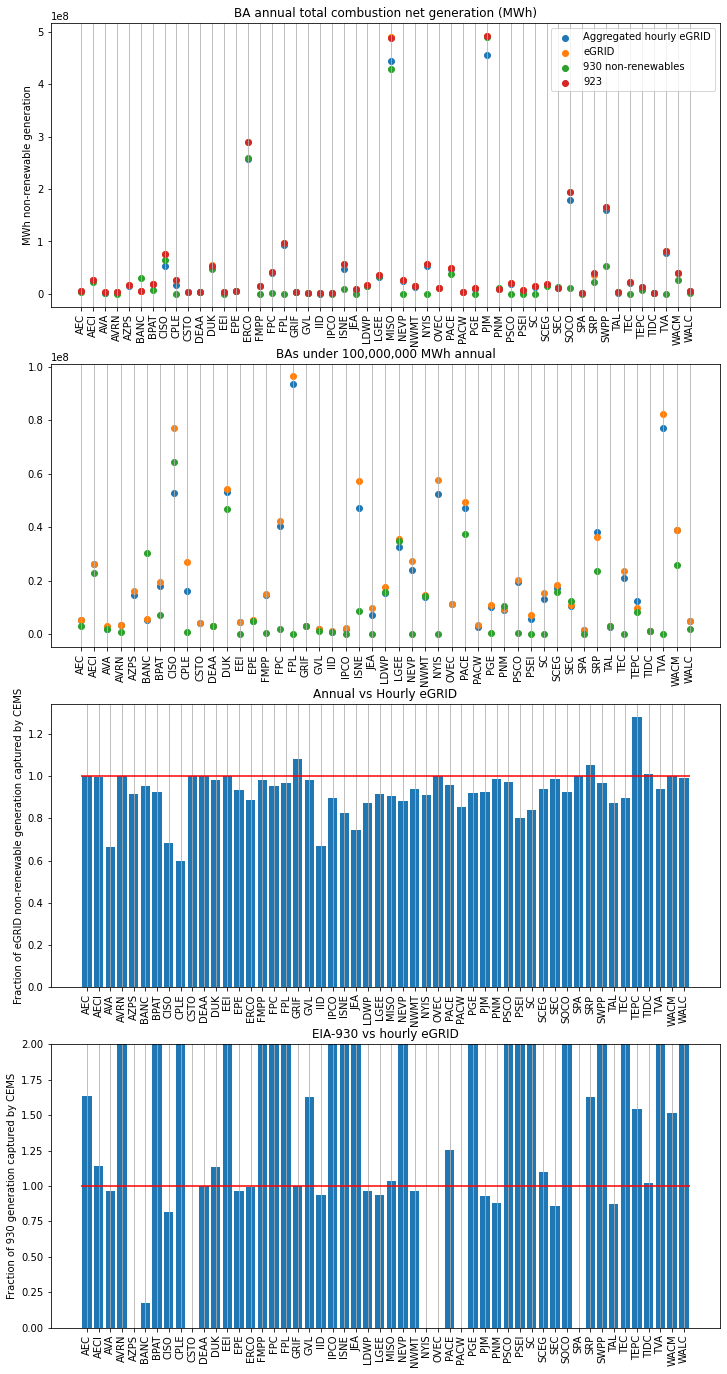

In [399]:
fig, (ax, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(12,24))

## Note: 923 and eGRID exactly agree, so points are on top of one another. 
ax.scatter(annual_generation.index, annual_generation["hourly"].tolist(), label="Aggregated hourly eGRID")
ax.scatter(annual_generation.index, annual_generation["BAGENACY"].tolist(), label="eGRID")
ax.scatter(annual_generation.index, annual_generation["930_generation_non_renewable"].tolist(), label="930 non-renewables")
ax.scatter(annual_generation.index, annual_generation["annual_923_net_gen"].tolist(), label="923")
ax.legend()
ax.grid(axis='x')
ax.set_title(f"{egrid_data_code_to_name['BAGENACY']}")
ax.set_xticklabels(labels=annual_generation.index, rotation=90);
ax.set_ylabel("MWh non-renewable generation")

small = annual_generation[annual_generation["BAGENACY"] < 1e8]
ax1.scatter(small.index, small["hourly"].tolist())
ax1.scatter(small.index, small["BAGENACY"].tolist())
ax1.scatter(small.index, small["930_generation_non_renewable"].tolist(), label="930 non-renewables")
ax1.grid(axis='x')
ax1.set_title("BAs under 100,000,000 MWh annual")
ax1.set_xticklabels(labels=small.index, rotation=90);

ax2.bar(annual_generation.index, annual_generation["hourly"]/annual_generation["BAGENACY"])
ax2.grid(axis='x')
ax2.set_xticklabels(labels=annual_generation.index, rotation=90);
ax2.hlines([1.0], -.5, len(annual_generation)-0.5, color='r')
ax2.set_ylabel("Fraction of eGRID non-renewable generation captured by CEMS");
ax2.set_title("Annual vs Hourly eGRID")

ax3.bar(annual_generation.index, annual_generation["hourly"]/annual_generation["930_generation_non_renewable"])
ax3.grid(axis='x')
ax3.set_xticklabels(labels=annual_generation.index, rotation=90);
ax3.hlines([1.0], -.5, len(annual_generation)-0.5, color='r')
ax3.set_ylabel("Fraction of 930 generation captured by CEMS");
ax3.set_ylim(0,2)
ax3.set_title("EIA-930 vs hourly eGRID")

In [381]:
# Many small BAs have terrible coverage of EIA-930 data, resulting in low annually aggregated 930 numbers.
# The worst discrepencies between 930 and eGRID:
annual_generation.loc[["FPL","IPCO","NEVP","SC","TEC","TVA"],:]

,hourly,BAGENACY,930_generation_non_renewable,930_generation_minus_renewable,annual_923_net_gen
FPL,4.851078e+08,9.636939e+07,103479.0,118116.0,9.637113e+07
IPCO,2.342146e+06,2.364719e+06,2053.0,2318.0,2.299064e+06
NEVP,7.269480e+07,2.731401e+07,41456.0,47816.0,2.729249e+07
SC,4.289300e+07,1.552237e+07,76362.0,75027.0,1.552237e+07
TEC,7.062291e+07,2.348435e+07,99507.0,189157.0,2.208424e+07
TVA,2.592488e+08,8.214065e+07,41558.0,42154.0,8.214070e+07


# 5. Compare eGRID to 923

/var/folders/mr/3dcnnc3153j6s05bmdwr0r0h0000gq/T/ipykernel_85695/673855858.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=annual_generation.index, rotation=90);


Text(0.5, 1.0, '923 vs eGRID')

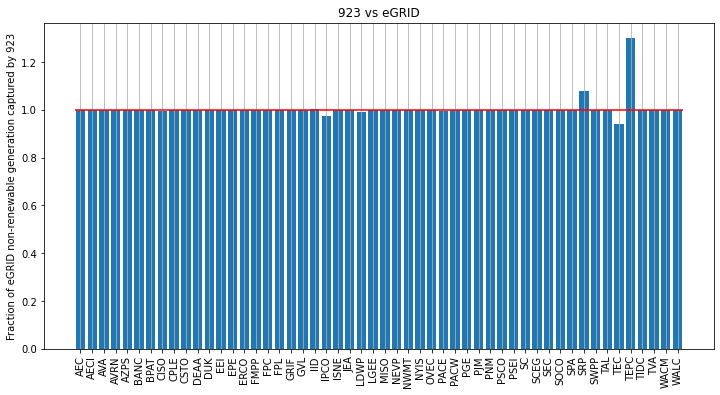

In [356]:
fig, (ax) = plt.subplots(1, figsize=(12, 6))

ax.bar(annual_generation.index, annual_generation["annual_923_net_gen"]/annual_generation["BAGENACY"])
ax.grid(axis='x')
ax.set_xticklabels(labels=annual_generation.index, rotation=90);
ax.hlines([1.0], -.5, len(annual_generation)-0.5, color='r')
ax.set_ylabel("Fraction of eGRID non-renewable generation captured by 923");
ax.set_title("923 vs eGRID")